In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import numpy as np

import math
from torch import Tensor
from typing import List, Optional
from torch.optim import Optimizer

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from IPython import display

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Including data

In [5]:
data_path = 'C:/Users/GP60/13.Gradient_clipping/datasets/data'

train_path = data_path + "/train"
val_path = data_path + "/val"

## Preprocessing images

In [31]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

input_size = 224
batch_size = 100
n_worker = 2

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        train_path, transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])),
    batch_size = batch_size, shuffle = True,
    num_workers = n_worker, pin_memory = True)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_path, transforms.Compose([
        transforms.Resize(int(input_size / 0.875)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,    
    ])),
    batch_size = batch_size, shuffle = False,
    num_workers = n_worker, pin_memory = True)

n_class = 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


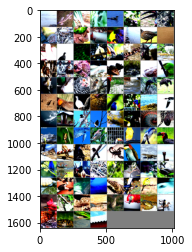

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, _ = iter(train_loader).next()

imshow(torchvision.utils.make_grid(images))

## Optimizer

In [12]:
def _make_sparse(grad, grad_indices, values):
    size = grad.size()
    if grad_indices.numel() == 0 or values.numel() == 0:
        return torch.empty_like(grad)
    return torch.sparse_coo_tensor(grad_indices, values, size)


def clipped_gradient_descent_step(params: List[Tensor],
                                  d_p_list: List[Tensor],
                                  lr: float,
                                  clipping_type: str,
                                  clipping_level: float):
    grad_norm = 0.0
    
    #if clipping_type == 'norm':
        
    
    for i, param in enumerate(params):
        d_p = d_p_list[i]
        
        if clipping_type == 'no_clip':
            param.add_(d_p, alpha = lr)
        elif clipping_type == 'norm':
            for i, comp in enumerate(d_p_list):
                grad_norm += comp.norm()**2
            
            grad_norm = grad_norm ** 0.5
            param.add_(d_p, alpha = -lr*alpha)
        
        #'layer_wise' and 'coordinate_wise'

In [23]:
class _RequiredParameter(object):
    '''Singleton class representing a required parameter for an Optimizer.'''
    def __repr__(self):
        return '<required parameter>'

required = _RequiredParameter()

class _DependingParameter(object):
    '''Singleton class representing a parameter that depends on other for an Optimizer.'''
    def __init__(self, other_parameter_name):
        self.other_parameter_name = other_parameter_name
    
    def __repr__(self):
        return '<depends on {}>'.format(self.other_parameter_name)

depending = _DependingParameter


class clipped_SGD(Optimizer):
    
    def __init__(self, params, lr = required, clipping_type = "norm", clipping_level = depending('clipping_type')):
        
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        type_to_default_level = {
            'no_clip': 0.0,
            'norm': 10,
            'layer_wise': 10,
            'coordinate_wise': 0.5
        }
        
        if clipping_type not in type_to_default_level:
            raise ValueError("Invalid clipping type: {}, possible types are {}".\
                            format(lr, list(type_to_default_level.keys())))
        if not isinstance(clipping_level, depending) and clipping_level < 0.0:
            raise ValueError('Invalid clipping level: {}'.format(clipping_level))
        if isinstance(clipping_level, depending):
            clipping_level = type_to_default_level[clipping_type]
        defaults = dict(lr=lr, clipping_type=clipping_type, clipping_level=clipping_level)
        super(clipped_SGD, self).__init__(params, defaults)
    
    def __setstate__(self):
        super(clipped_SGD, self).__setstate__(state)
    
    
        
        
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        
        Args:
           closure (callable, optional): A closure that reevaluates the model"""
        loss=None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            lr = group['lr']
            
            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)
                    
            clipped_gradient_descent_step(
                params_with_grad,
                d_p_list,
                lr,
                clipping_type,
                clipping_level)
        return loss
    

def clipped_step(params: List[Tensor],
                 d_p_list: List[Tensor],
                 momentum_buffer_list: List[Optional[Tensor]],
                 clipping_type: str,
                 weight_decay: float,
                 momentum: float,
                 lr: float,
                 dampening: float,
                 nesterov: bool):
    r"""Functional API that performs SGD algorithm computation.
    
    See :class:'clipped_SGD' for details.
    """
    
    for i, param in enumerate(params):
        d_p = d_p_list[i]
        if clipping_type == 'no_clip':
            param.add_(d_p, alpha = -lr)
        if (clipping_type == 'norm'):
            alpha = min(1, clipping_level / np.norm(d_p_list, 2))
            param.add_(d_p, alpha = -lr * alpha)

## Logistic Regression

In [17]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        outputs = self.linear(x)
        return outputs


In [18]:
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)
    
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))  #.contiguous()?
    
    res = []
    for k in tork:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res
        
        

## Graphics

In [19]:
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def smooth(a, eps=0.01):
    b = [a[0]]
    for e in a[1:]:
        b.append(b[-1] * (1 - eps) + e * eps)
    return b


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def make_loss_plot(ax, hist, eps=0.01, alpha=0.5):
    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]
        train_y, train_x = one_optim_hist["train_loss"], one_optim_hist["train_x"]
        val_y, val_x = one_optim_hist["val_loss"], one_optim_hist["val_x"]
        epochs_x = one_optim_hist["epochs_x"]

        if len(train_x) == 0:
            continue

        ax.plot(
            train_x, smooth(train_y, eps=eps), 
            label=label + " (train)", 
            alpha=alpha, color=colors[i], linestyle="-"
        )
        if len(val_x) > 0:
            ax.plot(
                val_x, val_y, 
                label=label + " (val)", 
                alpha=alpha, color=colors[i], linestyle="--"
            )

        #epoch sep lines
        for x in epochs_x:
            ax.axvline(x, linestyle="--", color=colors[i], alpha=0.2)

    ax.set_title("logloss на train и val для разных оптимизаторов")
    ax.set_ylabel("logloss")
    ax.set_xlabel("Число итераций")
    ax.grid(True)
    ax.legend()

    return ax

def make_accuracy_plot(ax, hist, eps=0.01, alpha=0.5, top_k=1):
    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]
        train_acc_top = one_optim_hist["train_acc_top_{}".format(top_k)]
        val_acc_top = one_optim_hist["val_acc_top_{}".format(top_k)]
        train_x = one_optim_hist["train_x"]
        val_x = one_optim_hist["val_x"]
        epochs_x = one_optim_hist["epochs_x"]

        if len(train_x) == 0:
            continue

        ax.plot(
            train_x, smooth(train_acc_top, eps=eps), 
            label=label + " (train)", 
            alpha=alpha, color=colors[i], linestyle="-"
        )
        if len(val_x) > 0:
            ax.plot(
                val_x, val_acc_top, 
                label=label + " (val)", 
                alpha=alpha, color=colors[i], linestyle="--"
            )

        #epoch sep lines
        for x in epochs_x:
            ax.axvline(x, linestyle="--", color=colors[i], alpha=0.2)

    ax.set_title("top-{} accuracy на train и val для разных оптимизаторов".format(top_k))
    ax.set_ylabel("top-{} accuracy".format(top_k))
    ax.set_xlabel("Число итераций")
    ax.grid(True)
    ax.legend()

    return ax

## Test

In [32]:
traindir = data_path + '/train'

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        traindir, transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])),
    batch_size = batch_size, shuffle=True,
    num_workers = n_worker, pin_memory=True)

valdir = data_path + '/val'

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(int(input_size / 0.875)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker, pin_memory=True)

n_class = 100

classes = [i for i in range(1, 101)]

In [33]:
#model = LogisticRegression() #input_dim and output_dim

models = [LogisticRegression(input_size, n_class), LogisticRegression(input_size, n_class)]

criterion = nn.CrossEntropyLoss()

opts = [
    clipped_SGD(models[0].parameters(), lr = 0.1, clipping_type = 'norm'),
    optim.SGD(models[1].parameters(), lr=0.1, momentum=0.9)
]

opt_names = [
    'clipped_SGD, 0.1, norm',
    'SGD, 0.1, 0.9'
]


hist = []

for (net, optimizer, opt_name) in zip(models, opts, opt_names):
    net.to(device)
    
    hist.append({
        'name': opt_name,
        'train_loss': [], 'train_x': [],
        'val_loss': [], 'val_x': [],
        'train_acc_top_1': [], 'train_acc_top_5': [],
        'val_acc_top_1': [], 'val_acc_top_5': [],
        'epochs_x': [],
        'total_steps': 0
    })


In [34]:
for epoch in range(20):
    for (model, optimizer, net_hist) in zip(models, opts, hist):
        total_steps = net_hist['total_steps']
        net_hist['epochs_x'].append(total_steps)
        
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            net_hist['train_loss'].append(loss.detach().cpu())
            net_hist['train_x'].append(total_steps)
            
            top_1, top_5 = accuracy(outputs.data, labels.data, topk(1, 5))
            net_hist['train_acc_top_1'].append(top_1.detach().cpu())
            net_hist['train_acc_top_5'].append(top_5.detach().cpu())
            
            #Print statistics
            if total_steps % 10 == 9:
                if total_steps % 500 == 499:
                    model.eval()
                    
                    imgs_to_print = []
                    val_losses = []
                    val_top_1_accs = []
                    val_top_5_accs = []
                    
                    for val_data in val_loader:
                        inputs, labels = val_data[0].to(device), val_data[1].to(device)
                        outputs = model(inpust)
                        val_losses.append(criterion(outputs, labels).detach().cpu())
                        
                        top_1, top_5 = accuracy(outputs.data, labels.data, topk = (1, 5))
                        val_top_1_accs.append(top_1.detach().cpu())
                        val_top_5_accs.append(top_5.detach().cpu())
                        
                    net_hist['val_loss'].append(np.mean(val_losses))
                    net_hist['val_x'].append(total_steps)
                    
                    net_hist['val_acc_top_1'].append(np.mean(val_top_1_accs))
                    net_hist['val_acc_top_5'].append(np.mean(val_top_5_accs))
                    
                    model.train()
                    
                display.clear_output(wait = True)
                
                fig = plt.figure(figsize=(15,12))
                gs = GridSpec(3,2, figure = fig)
                
                ax1=fig.add_subplot(gs[0:2,:])
                ax2=fig.add_subplot(gs[2,0])
                ax3=fig.add_subplot(gs[2,1])
                
                ax1=make_loss_plot(ax1, hist, eps=1e-2)
                ax2=make_accuracy_plot(ax2, hist, eps=1e-2, top_k=1)
                ax3=make_accuracy_plot(ax3, hist, eps=1e-2, top_k=5)
                
                plt.tight_layout()
                plt.draw()
                plt.show()
            
            total_steps += 1
        net_hist['total_steps'] = total_steps
    print('Finished Training')

RuntimeError: 1only batches of spatial targets supported (non-empty 3D tensors) but got targets of size: : [100]

In [3]:
1e-2

0.01